### Realized Volatility
---

Realized volatility is computed from historical data and is also called historical volatility.

It is defined as:

\begin{equation}
v(t_i) = v\left(\Delta t, n, p; t_i \right) = \left[\frac{1}{n-1}\sum^n_{j=1}\lvert r\left(\Delta t; t_{i-n+j} \right) \lvert^p \right]^{1/p}
\end{equation}

* The number of return observations is $n$
* There are two time intervals, the return interval $\Delta t$, and the size of the total sample $n \Delta t$ 
* Regularly spaced returns, $r(t_i)$, are given by the equation:

\begin{equation}
r(t_i) = r(\Delta t; t_i) = x(t_i) - x(t_i - \Delta t)
\end{equation}

where $x(t_i)$ is an homogeneous sequence of logarithmic prices and $\Delta t$ is a time interval of fixed size.

The exponent $p$ is often set to $2$ so that $v^2$ represents the variance of returns about zero, and the volatility definition can be rewritten as:

\begin{equation}
v(t_i) = \sqrt{\frac{\sum_{i=1}^n (r(t_i))^2}{n - 1}}
\end{equation}


This assumes no significant drift (mean return) over the study period, as opposed to certain definitions. Considering intraday data though, the drift can be considered null.  

### Annualization
---
Realized volatility is often presented in a scale form. Through  properties of Gaussian scaling law that states that variance is proportional to time, one can define annualized realized volatility as: 

\begin{equation}
v_{ann} = \sqrt{\frac{1year}{\Delta t}}v
\end{equation}


#### Practical considerations
---
* Choice of $\Delta t$: for a given constant sample size $T = n\Delta t$, $\Delta t$ should be chosen as small as possible. However, realized volatility results can become biased if $\Delta t$ is chosen to be too small. Best choice of $\Delta t$ is somewhere between 15 min and 2 hours, depending on market and data type
* For a given constant sample size $T = n\Delta t$, the value of realized volatility may change depending on the return resolution $\Delta t$

TODO: 
* Check if coarse realized volatility (large $\Delta t$) predicts the volatility of fine realized volatility (small $\Delta t$) better than the other way around
* For lower frequency (daily) data, models like GARCH and implied volatiluty models may yield better estimates than realized volatility
* For high frequency data, realized volatility models are better. Intraday data is hard to describe through homogeneous models such as GARCH because of seasonality and heterogeneity of the markets

#### Implementation
---

In [1]:
import numpy as np

In [2]:
import sys
sys.path.insert(0,'/home/ec2-user/SageMaker/core/analytics')
from utils import clamp

import numpy as np


class RealizedVolatility:
    """
    Inline realized volatility prediction model.
    """
    def __init__(self, delta_t: int, n: int = 12, cap: float = 3.5, floor: float = 0.10):
        """
        Parameters
        ----------
        delta_t: int
            The time interval in seconds used to compute returns.
        n: int
            The number of return observations used to compute volatility estimate.
        cap: float 
            Upper bound on realized volatility value.
        floor: float
            Lower bound on realized volatility value.
        """
        self.delta_t = delta_t
        self.n = n
        self.cap = cap
        self.floor = floor
        
        self.returns = []
        self.previous_ts = None
        self.previous_price = None
        
        self.SECONDS_PER_YEAR = 365.25 * 24 * 60 * 60
        
        
    def update(self, ts: int, price: float):
        """
        Upates state of the predictor given a new price coming in.
        Timestamps are assumed to be given in milliseconds.
        """
        # Initial run
        if self.previous_price is None:
            self.previous_ts = ts
            self.previous_price = price
            return
        
        # Compute returns (timestamps are assumed in milliseconds)
        if (ts - self.previous_ts) / 1000 < self.delta_t:
            return
        else:
            log_return = np.log(price/self.previous_price)
            self.returns.append(log_return)
            self.previous_ts = ts
            self.previous_price = price
            
        # Update lookback window
        if len(self.returns) > self.n:
            self.returns.pop(0)
        
        
    def predict(self):
        """
        Returns realized volatility value.
        """
        # Check wether we have some updated information 
        if len(self.returns) < self.n: 
            return np.nan
        
        # Compute realized volatility
        vol = np.array([x**2 for x in self.returns]).sum()
        vol = np.sqrt(vol / (self.n - 1))
        
        # Annualize
        vol = np.sqrt(self.SECONDS_PER_YEAR / self.delta_t) * vol 
        
        # Return
        return clamp(vol, self.floor, self.cap)
        

#### Study
---

In [3]:
import time
import sys 

import matplotlib.pyplot as plt
import pandas as pd

In [4]:
sys.path.insert(0,'/home/ec2-user/SageMaker/core/loaders')
from ch_kaikopublictrades import KaikoTradeLoader

In [5]:
exchange = 'huobi'
symbol = 'ethusdt'
start_date = '2022-03-01 00:00:00'
end_date = '2022-03-01 23:59:59'
interval = ' 1 SECOND '
tick = 0.01
tz = 'UTC'

tl = KaikoTradeLoader(tz)

In [6]:
start_time = time.perf_counter()
public_trades = tl.get_public_trades(exchange, symbol, start_date, end_date)
end_time = time.perf_counter()
print(f"Time elapsed: {end_time - start_time:0.4f} seconds")
public_trades

Time elapsed: 6.4211 seconds


,exchange,symbol,ts,price,amount,side
0,huobi,ethusdt,1646092800016,2920.84,0.5581,1
1,huobi,ethusdt,1646092800300,2921.12,0.0523,1
2,huobi,ethusdt,1646092801140,2921.41,1.4760,1
3,huobi,ethusdt,1646092801153,2921.61,0.3000,1
4,huobi,ethusdt,1646092802224,2922.13,0.0010,-1
...,...,...,...,...,...,...
408737,huobi,ethusdt,1646179195010,2975.85,0.4752,-1
408738,huobi,ethusdt,1646179195010,2975.85,2.5000,-1
408739,huobi,ethusdt,1646179195010,2975.85,0.2475,-1
408740,huobi,ethusdt,1646179195191,2975.85,0.0031,-1


<AxesSubplot:>

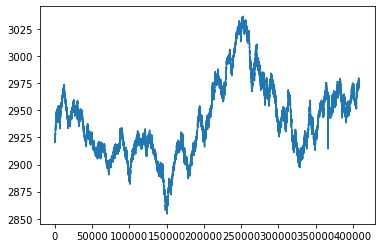

In [7]:
public_trades.price.plot()

In [11]:
realized_volatility = RealizedVolatility(delta_t = 300, n = 12, floor = 0.3, cap = 3.0)
lst_vol = []

for _, row in public_trades.iterrows():
    realized_volatility.update(row['ts'], row['price'])
    lst_vol.append(realized_volatility.predict())
    
ser_vol = pd.Series(lst_vol, index=public_trades['ts'])

<AxesSubplot:xlabel='ts'>

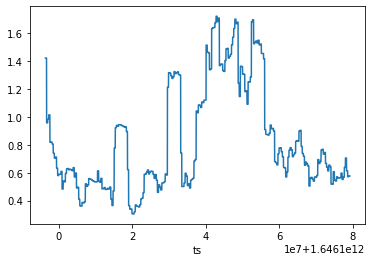

In [12]:
ser_vol.plot()

<AxesSubplot:ylabel='Price'>

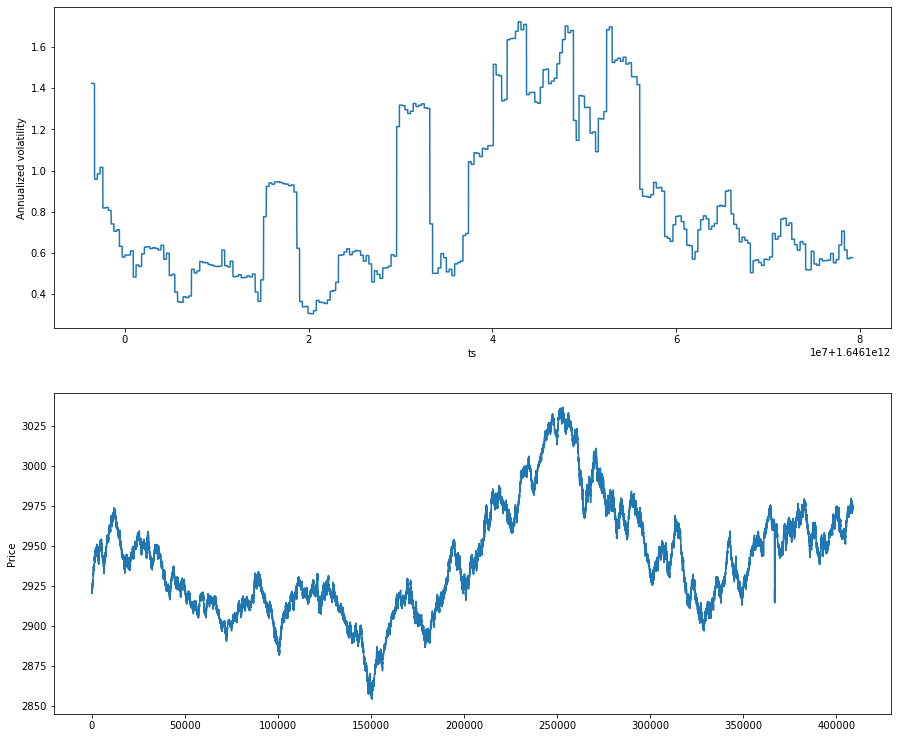

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,13))
axs[0].set_ylabel('Annualized volatility')
axs[1].set_ylabel('Price')
ser_vol.plot(ax=axs[0])
public_trades.price.plot(ax=axs[1])